# Read Data

In [1]:
import pandas as pd
from warnings import filterwarnings
filterwarnings("ignore")

import os
os.chdir("/users/bajajvbh/Desktop/Projects/Project_housing/")

trd = pd.read_csv("training_set.csv")
tsd = pd.read_csv("testing_set.csv")

# Missing Data treatment

In [2]:
#trd.isna().sum()

In [3]:
cols = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

In [4]:
for i in cols:
    trd[i]=trd[i].fillna("None")
    tsd[i]=tsd[i].fillna("None")

In [5]:
#trd.isna().sum()

In [6]:
from PM8wd import replacer
replacer(trd)
replacer(tsd)

# Outlier detection and removal

In [7]:
from PM8wd import catconsep
cat,con = catconsep(trd)

Dropping from training set

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X1 = pd.DataFrame(ss.fit_transform(trd[con]),columns=con)

In [9]:
outliers = []
for i in con:
    outliers.extend(list(X1[(X1[i]>3)|(X1[i]<-3)].index))
    
from numpy import unique
outliers = unique(outliers)

In [10]:
trd = trd.drop(index=outliers,axis=0)
trd.index = range(0,trd.shape[0])

In [11]:
#trd.shape

# Same steps for testing set

In [12]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
con.remove("SalePrice")
X1 = pd.DataFrame(ss.fit_transform(tsd[con]),columns=con)

outliers = []
for i in con:
    outliers.extend(list(X1[(X1[i]>3)|(X1[i]<-3)].index))
    
from numpy import unique
outliers = unique(outliers)

tsd = tsd.drop(index=outliers,axis=0)
tsd.index = range(0,tsd.shape[0])

# EDA

In [13]:
Y = trd[["SalePrice"]]
X = trd.drop(labels=["Id","SalePrice"],axis=1)

In [14]:
cat,con = catconsep(X)

In [15]:
Q = trd.corr()[["SalePrice"]].sort_values(by="SalePrice")
Q1 = list(Q[Q.SalePrice>0.2].index)

In [16]:
imp_con_cols = Q1[0:len(Q1)-1]

In [17]:
from PM8wd import ANOVA
imp_cat = []
for i in cat:
    q = ANOVA(trd,i,"SalePrice")
    if(q<0.05):
        imp_cat.append(i)

In [18]:
#imp_cat

# Preprocessing

In [19]:
ss = StandardScaler()
X1 = pd.DataFrame(ss.fit_transform(trd[imp_con_cols]),columns=imp_con_cols)
X2 = pd.get_dummies(trd[imp_cat])
Xnew = X1.join(X2)

In [20]:
Xnew.shape

(1015, 246)

In [21]:
Y.shape

(1015, 1)

# Split

In [22]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=31)

# Model

In [23]:
from statsmodels.api import OLS,add_constant
xconst = add_constant(xtrain)
ols = OLS(ytrain,xconst)
model = ols.fit()
print(round(model.rsquared_adj,4),"\n\n")
col_to_drop = model.pvalues.sort_values().index[-1]

0.9294 




# Loop for dropping columns

In [24]:
rsq = []
dropped_columns = []
Q = range(1,125)
for i in Q:
    Xnew = Xnew.drop(labels=col_to_drop,axis=1)
    xtrain,xtest,ytrain,ytest=train_test_split(Xnew,Y,test_size=0.2,random_state=31)
    xconst = add_constant(xtrain)
    ols = OLS(ytrain,xconst)
    model = ols.fit()
    rsq.append(round(model.rsquared_adj,4))
    dropped_columns.append(col_to_drop)
    col_to_drop = model.pvalues.sort_values().index[-1]
    

In [25]:
import matplotlib.pyplot as plt
plt.plot(Q,rsq)

In [27]:
#list(enumerate(dropped_columns))

# Create a Linear model for selected columns

In [26]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(xtrain,ytrain)
pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)
from sklearn.metrics import mean_squared_error
tr_err = mean_squared_error(ytrain,pred_tr)
ts_err = mean_squared_error(ytest,pred_ts)

In [27]:
tr_err

230833753.42857143

In [28]:
ts_err

7.889773715188213e+27

In [29]:
from numpy import sqrt
trnew = sqrt(tr_err)
tsnew = sqrt(ts_err)

In [30]:
trnew

15193.214058538484

In [31]:
tsnew

88824398197726.12

# Regularize

In [32]:
lambdas = []
q = 0.00
for i in range(0,1000):
    q = round(q + 0.01,2)
    lambdas.append(q)

In [34]:
tr = []
ts = []
for i in lambdas:
    from sklearn.linear_model import Ridge
    rr = Ridge(alpha=i)
    model = rr.fit(xtrain,ytrain)
    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)
    from sklearn.metrics import mean_squared_error
    tr_err = mean_squared_error(ytrain,pred_tr)
    ts_err = mean_squared_error(ytest,pred_ts)
    tr.append(tr_err)
    ts.append(ts_err)

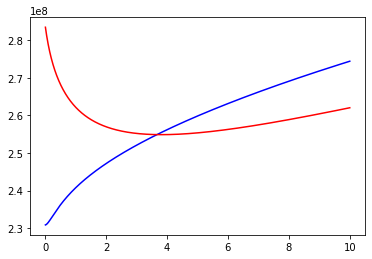

In [35]:
plt.plot(lambdas,tr,c="blue")
plt.plot(lambdas,ts,c="red")

In [46]:
tr = []
ts = []
for i in [3.6,3.7]:
    from sklearn.linear_model import Ridge
    rr = Ridge(alpha=i)
    model = rr.fit(xtrain,ytrain)
    pred_tr = model.predict(xtrain)
    pred_ts = model.predict(xtest)
    from sklearn.metrics import mean_squared_error
    tr_err = mean_squared_error(ytrain,pred_tr)
    ts_err = mean_squared_error(ytest,pred_ts)
    tr.append(tr_err)
    ts.append(ts_err)

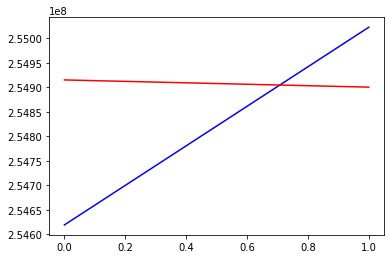

In [47]:
plt.plot(tr,c="blue")
plt.plot(ts,c="red")

In [48]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=3.7)
model = rr.fit(xtrain,ytrain)
pred_tr = model.predict(xtrain)
pred_ts = model.predict(xtest)
from sklearn.metrics import mean_squared_error
tr_err = mean_squared_error(ytrain,pred_tr)
ts_err = mean_squared_error(ytest,pred_ts)
print("Training Error: ",tr_err)
print("Testing Error: ",ts_err)

Training Error:  255022334.43002748
Testing Error:  254900208.1879022


# Cross Validation

In [49]:
tuning_grid = {"alpha":lambdas}
rr = Ridge()
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rr,tuning_grid,scoring="neg_mean_squared_error",cv=10)
cvmodel = cv.fit(Xnew,Y)
cvmodel.best_params_

{'alpha': 0.22}

# Create final model

In [51]:
from sklearn.linear_model import Ridge
rr = Ridge(alpha=0.22)
model = rr.fit(Xnew,Y)

# Create Final Predcitions on test Data

In [54]:
Xnew.shape

(1015, 122)

In [63]:
X1_test = pd.DataFrame(ss.transform(tsd[X1.columns]),columns=X1.columns)

In [69]:
cat,con = catconsep(tsd)
X2_prov = pd.get_dummies(tsd[cat])

In [70]:
for i in ['Exterior2nd_Other', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Heating_Grav', 'Exterior2nd_Stone', 'Heating_Floor', 'Heating_Wall', 'GarageQual_Ex']:
    X2_prov[i]=0

In [73]:
X2_final = X2_prov[X2.columns]

In [79]:
final_X = X1_test.join(X2_final)
final_X = final_X[Xnew.columns]

In [80]:
Xnew.shape

(1015, 122)

In [81]:
final_X.shape

(1019, 122)

# Predictions

In [87]:
Q = []

for i in model.predict(final_X):
    Q.append(round(i[0],2))

In [91]:
Q1 = pd.DataFrame([tsd.Id]).T

In [93]:
Q1['Predicted_SalePrice']=Q

In [95]:
Q1.to_csv("submissions.csv")